In [9]:
paziente = 1
quadro = 14

In [10]:
import pandas as pd

df_gaze = pd.read_csv(f'ProcessingCSV/SoggettoQuadro/GazeRAW/S{paziente}_Q{quadro}.csv')

df_gaze.head()

,tBlink-iniziale,tBlink-finale,durataBlink,tFixation-iniziale,tFixation-finale,durataFixation,tSaccade-iniziale,tSaccade-finale,durataSaccade
0,NaN,NaN,NaN,54855156.0,54856382.0,1226.0,54855156.0,54855398.0,242.0
1,NaN,NaN,NaN,54856697.0,54856858.0,161.0,54855487.0,54855721.0,234.0
2,NaN,NaN,NaN,54857262.0,54857835.0,573.0,54855890.0,54856156.0,266.0
3,NaN,NaN,NaN,54858730.0,54858981.0,251.0,54856302.0,54856778.0,476.0
4,NaN,NaN,NaN,54859287.0,54861046.0,1759.0,54856858.0,54857109.0,251.0


In [11]:
df_pupil = pd.read_csv(f'ProcessingCSV/SoggettoQuadro/PupilData/S{paziente}_Q{quadro}.csv')

df_pupil['TIMESTAMP'] = df_pupil['TIMESTAMP'] / 1000000

df_pupil.head()

,TIMESTAMP,DIAM,CONF
0,54855075.0,44.148335,0.946043
1,54855156.0,44.283894,0.946506
2,54855237.0,44.160336,0.844366
3,54855317.0,44.263248,0.886083
4,54855398.0,44.334782,0.873504


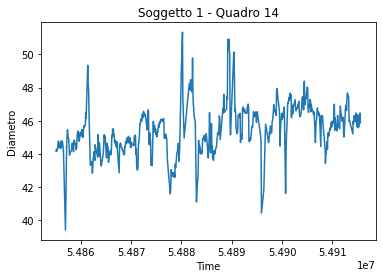

In [12]:
import matplotlib.pyplot as plt

df_plot = df_pupil[(df_pupil['CONF'] > 0.70) & (df_pupil['DIAM'] > 35) & (df_pupil['DIAM'] < 80)]
plt.plot(df_plot['TIMESTAMP'], df_plot['DIAM'])
plt.xlabel('Time')
plt.ylabel('Diametro')
plt.title(f'Soggetto {paziente} - Quadro {quadro}')
plt.show()

In [13]:
df_session = pd.read_csv(f'ProcessingCSV/SoggettoQuadro/SessioniEMPTY/S{paziente}_Q{quadro}.csv')

df_session.head()

,timestamp
0,54855075.0
1,54855076.0
2,54855077.0
3,54855078.0
4,54855079.0


In [14]:
#Creo le colonne per le fixations, saccades e diametro ts per ts
df_session['Fixation'] = 0
df_session['Saccade'] = 0
df_session['Diametro'] = 0

for _, row in df_gaze.iterrows():
    fixation_mask = (df_session['timestamp'] >= row['tFixation-iniziale']) & (df_session['timestamp'] <= row['tFixation-finale'])
    df_session.loc[fixation_mask, 'Fixation'] = row['durataFixation']

    saccade_mask = (df_session['timestamp'] >= row['tSaccade-iniziale']) & (df_session['timestamp'] <= row['tSaccade-finale'])
    df_session.loc[saccade_mask, 'Saccade'] = row['durataSaccade']

df_session[df_session['Fixation'] > 0]

,timestamp,Fixation,Saccade,Diametro
81,54855156.0,1226.0,242,0
82,54855157.0,1226.0,242,0
83,54855158.0,1226.0,242,0
84,54855159.0,1226.0,242,0
85,54855160.0,1226.0,242,0
...,...,...,...,...
60482,54915557.0,1509.0,250,0
60483,54915558.0,1509.0,250,0
60484,54915559.0,1509.0,250,0
60485,54915560.0,1509.0,250,0


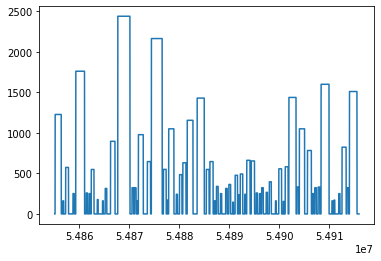

In [15]:
plt.plot(df_session['timestamp'], df_session['Fixation'])
plt.show()

In [16]:
for i, row in df_pupil.iterrows():
    if i < len(df_pupil) - 1:
        # Assegna il Diametro a tutti i timestamp fino al prossimo timestamp di campionamento
        mask = (df_session['timestamp'] >= row['TIMESTAMP']) & (df_session['timestamp'] < df_pupil.iloc[i + 1]['TIMESTAMP'])
    else:
        # Per l'ultimo campionamento, assegna il Diametro a tutti i timestamp rimanenti
        mask = (df_session['timestamp'] >= row['TIMESTAMP'])
    df_session.loc[mask, 'Diametro'] = row['DIAM']

df_session

,timestamp,Fixation,Saccade,Diametro
0,54855075.0,0.0,0,44.148335
1,54855076.0,0.0,0,44.148335
2,54855077.0,0.0,0,44.148335
3,54855078.0,0.0,0,44.148335
4,54855079.0,0.0,0,44.148335
...,...,...,...,...
60901,54915976.0,0.0,0,0.000000
60902,54915977.0,0.0,0,0.000000
60903,54915978.0,0.0,0,0.000000
60904,54915979.0,0.0,0,0.000000


In [17]:
import numpy as np

# Definisci le finestre
windows = [
    {'size': 5000, 'overlap': 1000},
    {'size': 15000, 'overlap': 5000}
]




# Funzione per calcolare le statistiche
def calculate_stats(df, start, end):
    sub_df = df.iloc[start:end]
    stats = {
        'mean-value': sub_df.mean(),
        'min': sub_df.replace(0, np.nan).min(),  # Sostituisci 0 con NaN prima di calcolare il minimo
        'max': sub_df.max(),
        'dev-stand': sub_df.std(),
        'num_diff_nonzero': sub_df[sub_df != 0].nunique()
    }
    return stats





for window in windows:
    size, overlap = window['size'], window['overlap']

    results = []

    for start in range(0, df_session.shape[0], size - overlap):
        end = min(start + size, df_session.shape[0])
        stats = calculate_stats(df_session[['Fixation', 'Saccade', 'Diametro']], start, end)
        results.append([start, *stats['mean-value'], *stats['min'], *stats['max'], *stats['dev-stand'], *stats['num_diff_nonzero']])
    
    if size == 5000:
        small_df = pd.DataFrame(results, columns=['window', 'mean_Fixation', 'mean_Saccade', 'mean_Diametro', 'min_Fixation', 'min_Saccade', 'min_Diametro', 'max_Fixation', 'max_Saccade', 'max_Diametro', 'std_Fixation', 'std_Saccade', 'std_Diametro', 'num_diff_nonzero_Fixation', 'num_diff_nonzero_Saccade', 'num_diff_nonzero_Diametro'])
    else:
        medium_df = pd.DataFrame(results, columns=['window', 'mean_Fixation', 'mean_Saccade', 'mean_Diametro', 'min_Fixation', 'min_Saccade', 'min_Diametro', 'max_Fixation', 'max_Saccade', 'max_Diametro', 'std_Fixation', 'std_Saccade', 'std_Diametro', 'num_diff_nonzero_Fixation', 'num_diff_nonzero_Saccade', 'num_diff_nonzero_Diametro'])
    
# Calcola le statistiche sull'intera lunghezza
full_stats = calculate_stats(df_session[['Fixation', 'Saccade', 'Diametro']], 0, df_session.shape[0])
full_results = [[*full_stats['mean-value'], *full_stats['min'], *full_stats['max'], *full_stats['dev-stand'], *full_stats['num_diff_nonzero']]]
full_window_df = pd.DataFrame(full_results, columns=['mean_Fixation', 'mean_Saccade', 'mean_Diametro', 'min_Fixation', 'min_Saccade', 'min_Diametro', 'max_Fixation', 'max_Saccade', 'max_Diametro', 'std_Fixation', 'std_Saccade', 'std_Diametro', 'num_diff_nonzero_Fixation', 'num_diff_nonzero_Saccade', 'num_diff_nonzero_Diametro'])



In [18]:
small_df.head()

,window,mean_Fixation,mean_Saccade,mean_Diametro,min_Fixation,min_Saccade,min_Diametro,max_Fixation,max_Saccade,max_Diametro,std_Fixation,std_Saccade,std_Diametro,num_diff_nonzero_Fixation,num_diff_nonzero_Saccade,num_diff_nonzero_Diametro
0,0,661.7260,170.7368,38.811077,161.0,226.0,39.406433,1759.0,476.0,49.729191,678.527860,155.854045,14.992050,5,8,54
1,4000,711.5540,199.2802,40.416826,177.0,226.0,41.074184,1759.0,581.0,49.421207,789.687498,184.636999,13.532071,5,7,57
2,8000,376.8956,213.2944,35.498608,161.0,226.0,30.374325,2437.0,581.0,45.717216,679.053720,198.731058,17.264008,5,8,51
3,12000,1296.9030,156.6192,40.991402,161.0,210.0,30.374325,2437.0,396.0,46.130028,1134.793241,140.352195,11.200668,6,6,59
4,16000,1014.8604,113.2612,43.834349,161.0,210.0,43.019264,2162.0,314.0,46.652763,876.000313,126.296453,8.084404,5,5,61


In [19]:
medium_df.head()

,window,mean_Fixation,mean_Saccade,mean_Diametro,min_Fixation,min_Saccade,min_Diametro,max_Fixation,max_Saccade,max_Diametro,std_Fixation,std_Saccade,std_Diametro,num_diff_nonzero_Fixation,num_diff_nonzero_Saccade,num_diff_nonzero_Diametro
0,0,813.818667,175.484000,38.797232,161.0,226.0,30.374325,2437.0,581.0,49.729191,918.542944,166.362207,14.863554,12,13,163
1,10000,975.294533,160.753467,40.711834,161.0,210.0,30.374325,2437.0,726.0,49.072548,955.389001,180.921680,12.527952,14,10,171
2,20000,655.247733,180.842000,38.176895,161.0,234.0,13.599178,2162.0,726.0,52.675476,697.423085,206.894697,16.559119,16,11,158
3,30000,213.291600,207.670800,36.895935,145.0,234.0,13.042602,661.0,549.0,52.675476,247.183715,181.643298,18.045284,19,17,152
4,40000,525.328000,206.261867,39.259633,154.0,234.0,13.042602,1598.0,758.0,49.963573,588.111858,205.437418,16.161336,14,17,159


In [20]:
full_window_df.head()

,mean_Fixation,mean_Saccade,mean_Diametro,min_Fixation,min_Saccade,min_Diametro,max_Fixation,max_Saccade,max_Diametro,std_Fixation,std_Saccade,std_Diametro,num_diff_nonzero_Fixation,num_diff_nonzero_Saccade,num_diff_nonzero_Diametro
0,620.793781,182.072045,40.888457,145.0,210.0,10.376008,2437.0,758.0,1098.713379,722.379342,190.494802,44.817042,44,36,652


In [21]:
small_df = small_df.drop(columns=['window'])
medium_df = medium_df.drop(columns=['window'])

# Calcola le medie per ogni set di dati
small_means = small_df.mean().add_suffix('_small')
medium_means = medium_df.mean().add_suffix('_medium')
full_means = full_window_df.mean().add_suffix('_full')

# Crea una Serie con i risultati
result = pd.concat([pd.Series({'ID': paziente, 'PAINTING': quadro}), small_means, medium_means, full_means])

result

ID                                     1.000000
PAINTING                              14.000000
mean_Fixation_small                  613.497545
mean_Saccade_small                   178.172928
mean_Diametro_small                   41.100710
min_Fixation_small                   261.125000
min_Saccade_small                    231.500000
min_Diametro_small                    27.660910
max_Fixation_small                  1547.062500
max_Saccade_small                    513.500000
max_Diametro_small                   179.734193
std_Fixation_small                   621.099653
std_Saccade_small                    179.415283
std_Diametro_small                    31.641099
num_diff_nonzero_Fixation_small        5.625000
num_diff_nonzero_Saccade_small         6.437500
num_diff_nonzero_Diametro_small       51.562500
mean_Fixation_medium                 657.424525
mean_Saccade_medium                  174.084338
mean_Diametro_medium                  38.881245
min_Fixation_medium                  350